# 작업 진행 순서

1. 데이터 로딩
2. 데이터 텐서화, x/y 나누기
3. 전처리
4. train, valid, test로 나누기
5. 모델, 옵티마이저, 손실함수 설정
6. 가능하면 gpu로 이동
7. 학습
    1. 하이퍼 파라미터 정의
    1. 미니배치로 나누고 iteration만큼 학습
    2. 한 epoch 학습시 valid set으로 테스트
    3. epoch 수만큼 무한 반복 or valid loss가 일정 횟수만큼 안떨어지면 중단
8. test로 검증

# 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
display(train_df.tail())
display(test_df.tail())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_X = torch.tensor(train_df.values[:, 1:])
train_y = torch.tensor(train_df.values[:, :1])
test_X = torch.tensor(test_df.values)

In [5]:
print(train_X.shape)
print(train_y.shape)

torch.Size([42000, 784])
torch.Size([42000, 1])


In [6]:
def plot(x):
    img = x.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

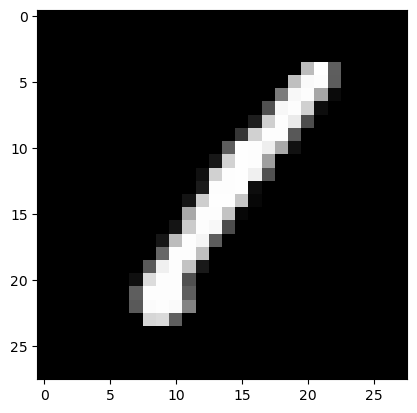

In [7]:
plot(train_X[0])

# 전처리

In [8]:
train_X = train_X / 255

# Train, Valid 나누기

In [9]:
train_size = int(train_X.size(0) * 0.8)
valid_size = int(train_X.size(0) * 0.2)
print(train_size, valid_size)

33600 8400


In [10]:
train_X, valid_X = train_X.split([train_size, valid_size], dim=0)
train_y, valid_y = train_y.split([train_size, valid_size], dim=0)

In [11]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape)

torch.Size([33600, 784]) torch.Size([33600, 1])
torch.Size([8400, 784]) torch.Size([8400, 1])
torch.Size([28000, 784])


# 모델 구성하기

In [12]:
class Block(nn.Module):
    def __init__(
            self, 
            input_size,
            output_size,
            use_batch_norm=True,
            dropout_p=0.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularization(use_batch_norm, output_size):
            return nn.BatchNorm1d(output_size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size), 
            nn.ReLU(),
            get_regularization(use_batch_norm, output_size)
        )

    def forward(self, x):
        y = self.block(x)
        return y

In [13]:
class MyModel(nn.Module):
    def __init__(self,
                input_size,
                output_size,
                use_batch_norm=True, 
                dropout_p=0.4):
        
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 400, use_batch_norm, dropout_p),
            Block(400, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            Block(50, 25, use_batch_norm, dropout_p),
            nn.Linear(25, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        y = self.layers(x)
        return y


In [14]:
input_size = train_X.size(-1)
output_size = int(train_y.max()) + 1

In [15]:
model = MyModel(input_size, output_size, True)
model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=400, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=200, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=200, out_features=100, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Block(
     

In [16]:
from torch import optim

In [17]:
crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# GPU가 있으면 이동

In [35]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [36]:
model.to(device)

train_X, train_y = train_X.to(device), train_y.to(device)
valid_X, valid_y = valid_X.to(device), valid_y.to(device)
test_X = test_X.to(device)

# 학습

In [44]:
n_epochs = 20
batch_size = 512
print_interval = 5

In [45]:
train_history, valid_history = [], []

In [46]:
from copy import deepcopy

best_model = None
lowest_loss = np.inf

lowest_epoch = 0

In [47]:
for i in range(n_epochs):
    model.train()
    indices = torch.randperm(train_X.size(0)).to(device)

    train_X_ = torch.index_select(train_X, dim=0, index=indices)
    train_y_ = torch.index_select(train_y, dim=0, index=indices)

    train_X_ = train_X_.split(batch_size, dim=0)
    train_y_ = train_y_.split(batch_size, dim=0)

    train_loss = 0

    for x, y in zip(train_X_, train_y_):
        y_pred = model(x)
        loss = crit(y_pred, y.squeeze())

        optimizer.zero_grad() # 이전 grad와 연결 끊기
        loss.backward()

        optimizer.step()
        train_loss+=float(loss) # 메모리 누수 방지를 위해 중요하다고 함

    train_loss = train_loss / len(train_X_)

    model.eval() # 검증 모드로 변경
    with torch.no_grad(): # 파라미터 업데이트 안함
        valid_X_ = valid_X.split(batch_size, dim=0)
        valid_y_ = valid_y.split(batch_size, dim=0)

        valid_loss = 0

        for x, y in zip(valid_X_, valid_y_):
            y_pred = model(x)
            loss = crit(y_pred, y.squeeze())

            valid_loss+=float(loss)

    valid_loss = valid_loss / len(valid_X_)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())

    if (i+1) % print_interval == 0:
        print(f'epoch {i+1} / train loss: {train_loss}, valid loss: {valid_loss}, lowest loss: {lowest_loss}')

print(f'lowest validation loss from epoch {lowest_epoch+1}: {lowest_loss}')
model.load_state_dict(best_model) # model에 best일 때의 파라미터를 불러와 적용

epoch 5 / train loss: 0.00020837605684805155, valid loss: 0.09967358026872664, lowest loss: 0.09910323273609667
epoch 10 / train loss: 8.579021579697093e-05, valid loss: 0.1003919300787589, lowest loss: 0.09839487481204902
epoch 15 / train loss: 6.266928038244122e-05, valid loss: 0.09988179978202372, lowest loss: 0.09839487481204902
epoch 20 / train loss: 5.582956989449237e-05, valid loss: 0.10238726645269815, lowest loss: 0.09839487481204902
lowest validation loss from epoch 9: 0.09839487481204902


<All keys matched successfully>